# Risk Simulation

In [1]:
#packages
import pandas as pd
import numpy as np
import math
import random
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from scipy.stats import *

Distribuciones de scipy y su documentación:
https://docs.scipy.org/doc/scipy/reference/stats.html

Distribuciones de numpy y su documentación:
https://numpy.org/doc/1.16/reference/routines.random.html

## Ajustar mejor distribución

In [2]:
#import volatilities
vols = pd.read_excel("vols.xlsx")
vols.head()

,Date,Coffee,COPUSD,CoffeeCOP
0,1991-01-03,0.285139,NaN,NaN
1,1991-01-04,0.285243,NaN,NaN
2,1991-01-07,0.285104,NaN,NaN
3,1991-01-08,0.284625,NaN,NaN
4,1991-01-09,0.284622,NaN,NaN


In [3]:
coffee = vols["Coffee"]
trm = vols["COPUSD"]
coffee_cop = vols["CoffeeCOP"]

coffee.dropna(inplace = True)
trm.dropna(inplace = True)
coffee_cop.dropna(inplace = True)

Solo Correr fitter una vez

--------------

In [ ]:
%%time
#from fitter import Fitter
#f1 = Fitter(coffee)
#f1.fit()
# may take some time since by default, all distributions are tried
# but you call manually provide a smaller set of distributions
#f1.summary()

In [ ]:
%%time
#f2 = Fitter(trm)
#f2.fit()
# may take some time since by default, all distributions are tried
# but you call manually provide a smaller set of distributions
#f2.summary()

In [ ]:
%%time
#f3 = Fitter(coffee_cop)
#f3.fit()
# may take some time since by default, all distributions are tried
# but you call manually provide a smaller set of distributions
#f3.summary()

-------------

Obtener parametros para las mejores distribuciones

In [ ]:
"""print("Parms of coffee",f1.fitted_param['dgamma'])
print("Parms of trm", f2.fitted_param['fatiguelife'])
print("Parms of coffee cop",f3.fitted_param['laplace'])"""

In [4]:
#definir inputs:
n = 5000
pct_cobertura = 0.3

#IBR
ibr_min = 0.01
ibr_c = 0.035
ibr_max = 0.05
ibr = np.random.triangular(ibr_min, ibr_c, ibr_max, size=n)

#LIBOR
lib_min = 0
lib_c = 0.029
lib_max = 0.038
lib = np.random.triangular(lib_min, lib_c, lib_max, size=n)

#Vol Café ------Limitar a valores positivos
vol_coffee = dgamma.rvs(1.4863778547163755, loc = 0.356, scale = 0.0465, size=n)
vol_coffee[vol_coffee < 0.0] = vol_coffee.mean()

#Vol Dólar
vol_trm = fatiguelife.rvs(0.5202 ,loc = 0.0139, scale = 0.0747, size = n)
vol_trm[vol_trm < 0.0] = vol_trm.mean()

#vol Cafe cop
vol_coffee_cop = laplace.rvs(loc = 0.2350, scale = 0.05825)



#precio café
#definir distribucion del café

#precio dólar
#definir distribucion del dolar - hacer browniano geométrico

## Black Scholes

In [5]:
from math import log, sqrt, pi, exp
from scipy.stats import norm
from datetime import datetime, date
import numpy as np
import pandas as pd
from pandas import DataFrame

In [6]:
def call(S,K,T,r,sigma):
    lns0k = log(S/K)
    rmas = (r+(sigma**2)/2.0)*T
    srt = sigma*sqrt(T)
    d1 = (lns0k + rmas) / srt
    d2 = d1 - srt
    Nd1 = norm.cdf(d1)
    Nd2 = norm.cdf(d2)
    ert = exp(-T*r)
    price = S*Nd1-K*ert*Nd2
    return(price)

## Simulación masiva

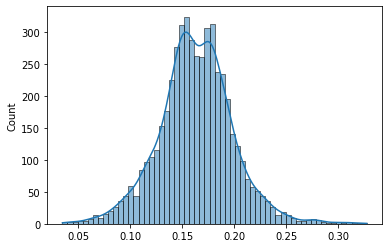

In [7]:
#simular primas café base
primas_pct = []

ss = -0.02 #Strike vs Spot
S = 100 #spot
K = S*(1+ss) #strike
T = 1 #time in years

for i in range(n):
    r = lib[i] #free risk interest rate
    sigma = vol_coffee[i] #volatility of asset (annualized)
    prima = call(S,K,T,r,sigma) # price of option in unites
    prima_pct = prima / K #price of option %
    primas_pct.append(prima_pct)
    
sns.histplot(primas_pct, kde=True)
plt.show()

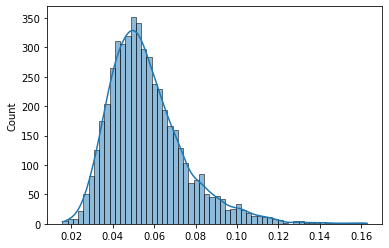

In [8]:
#simular primas trm
primas_pct = []

for i in range(n):
    ss = -0.02 #Strike vs Spot
    S = 3500 #spot
    K = S*(1+ss) #strike
    T = 1 #time in years
    r = ibr[i] - lib[i] #free risk interest rate
    sigma = vol_trm[i] #volatility of asset (annualized)
    prima = call(S,K,T,r,sigma) # price of option in unites
    prima_pct = prima / K #price of option %
    primas_pct.append(prima_pct)
    
sns.histplot(primas_pct, kde=True)
plt.show()

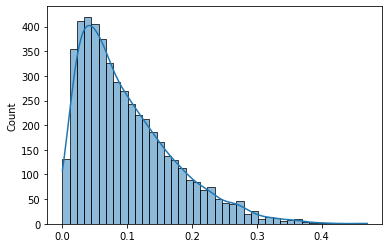

In [9]:
#inputs
S = 100 #spot coffee base
S2 = 3500 #spot trm base
T = 1 #time in years

#dist strike vs spot 
ss_array_coffee = np.random.triangular(-0.5, 0, 0.5, size=n) #Triangular con moda 0 min -50% y max +50%
ss_array_trm = np.random.triangular(-0.5, 0, 0.5, size=n) #Triangular con moda 0 min -50% y max +50%

#Combinacion de las dos primas
primas_pct = []
primas_pct2 = []
primas_pct_all = []


for i in range(n):
    #coffee
    ss =  ss_array_coffee[i] #Strike vs Spot
    K = S*(1+ss) #strike coffee
    r = lib[i] #free risk interest rate
    sigma = vol_coffee[i] #volatility of asset (annualized)
    prima = call(S,K,T,r,sigma) # price of option in unites
    prima_pct = prima / K #price of option %
    primas_pct.append(prima_pct)
    
    #trm
    ss2 = ss_array_trm[i]
    K2 = S2*(1+ss2)
    r2 = ibr[i] - lib[i]
    sigma2 = vol_trm[i]
    prima2 = call(S2, K2, T, r2, sigma2)
    prima_pct2 = prima2 / K2
    primas_pct2.append(prima_pct2)
    
    #combinacion
    prima_pct_all = (prima_pct + prima_pct2)*pct_cobertura
    primas_pct_all.append(prima_pct_all)
    
    
    
sns.histplot(primas_pct_all, kde=True)
plt.show()

## Simulación de precios futuros

### Geometric Brownian Motion GBM

In [10]:
# Parameter Definitions

# So    :   initial stock price
# dt    :   time increment -> a day in our case
# T     :   length of the prediction time horizon(how many time points to predict, same unit with dt(days))
# N     :   number of time points in the prediction time horizon -> T/dt
# t     :   array for time points in the prediction time horizon [1, 2, 3, .. , N]
# mu    :   mean of historical daily returns
# sigma :   standard deviation of historical daily returns
# b     :   array for brownian increments
# W     :   array for brownian path

### Simulación Precio Café

#### Yahoo Financie

In [11]:
import quandl
quandl.ApiConfig.api_key = "1VS8Ys2-9xQMfabc_KfS"

In [12]:
start_date = '2000-01-01'
end_date = '2021-03-31'
pred_end_date = '2021-09-30'

# We get daily closing prices for Coffee C Futures
kc = quandl.get("CHRIS/ICE_KC1", start_date=start_date, 
                    end_date=end_date).reset_index(drop = False)[['Date', 'Settle']]

In [17]:
returns = (kc.loc[1:, 'Settle'] - \
           kc.shift(1).loc[1:, 'Settle']) / \
           kc.shift(1).loc[1:, 'Settle']


# Parameter Assignments
So = kc.loc[kc.shape[0] - 1, "Settle"]
dt = 1 # day   # User input
n_of_wkdays = pd.date_range(start = pd.to_datetime(end_date, 
                 format = "%Y-%m-%d") + pd.Timedelta('1 days'), 
                 end = pd.to_datetime(pred_end_date, 
                 format = "%Y-%m-%d")).to_series().map(lambda x: 
                 1 if x.isoweekday() in range(1,6) else 0).sum()
Tb = n_of_wkdays # days  # User input -> follows from pred_end_date
N = Tb / dt
t = np.arange(1, int(N) + 1)
mu = np.mean(returns)
sigma = np.std(returns)
scen_size = 1000 # User input
b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}

In [18]:
drift = (mu - 0.5 * sigma**2) * t
diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}

In [19]:
# Making the predictions
S_c = np.array([So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)]) 
S_c = np.hstack((np.array([[So] for scen in range(scen_size)]), S_c)) # add So to the beginning series

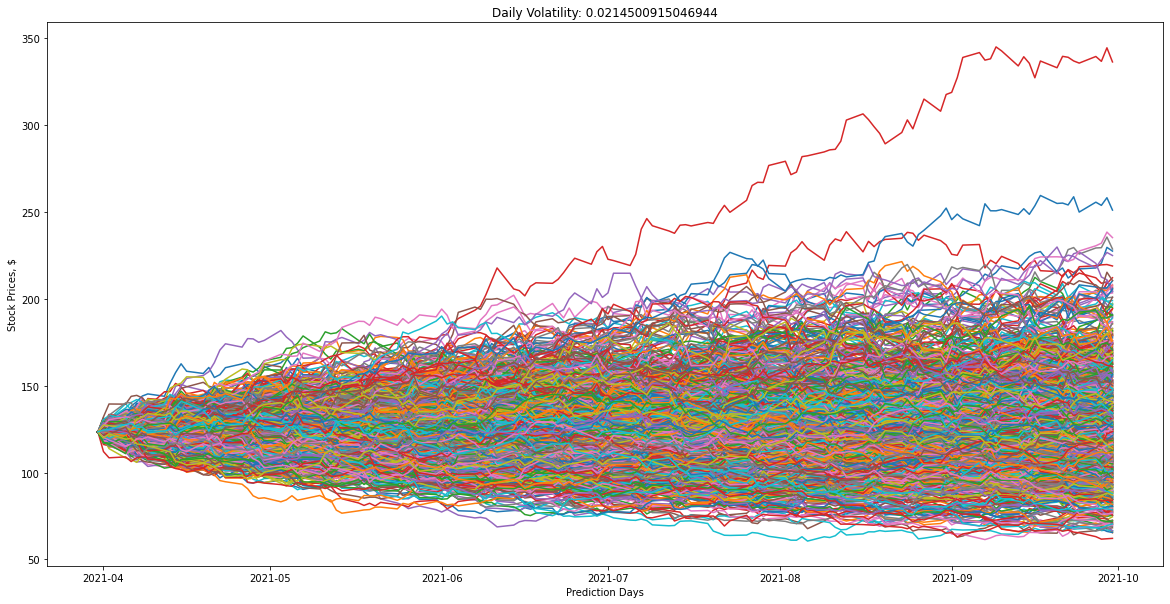

In [20]:

# Plotting the simulations
plt.figure(figsize = (20,10))
for i in range(scen_size):
    plt.title("Daily Volatility: " + str(sigma))
    plt.plot(pd.date_range(start = kc["Date"].max(), 
                end = pred_end_date, freq = 'D').map(lambda x:
                x if x.isoweekday() in range(1, 6) else np.nan).dropna(), S_c[i, :])
    plt.ylabel('Stock Prices, $')
    plt.xlabel('Prediction Days')
plt.show()

# Dataframe format for predictions - first 10 scenarios only
Preds_df_coffee = pd.DataFrame(S_c.swapaxes(0, 1)[:, :10]).set_index(
           pd.date_range(start = kc["Date"].max(), 
           end = pred_end_date, freq = 'D').map(lambda x:
           x if x.isoweekday() in range(1, 6) else np.nan).dropna()
           ).reset_index(drop = False)

### Movimiento Browniano COP / USD

In [21]:
import investpy

In [22]:
start_datei = '01/01/2000'
end_datei = '31/03/2021'
pred_end_datei = '30/09/2021'


df = investpy.get_currency_cross_historical_data(currency_cross='USD/COP',
                                                 from_date=start_datei,
                                                 to_date=end_datei).reset_index(drop = False)[['Date', 'Close']]
df.tail()

,Date,Close
5529,2021-03-26,3687.14
5530,2021-03-28,3689.89
5531,2021-03-29,3716.24
5532,2021-03-30,3727.25
5533,2021-03-31,3658.95


In [26]:
returns_trm = df["Close"].pct_change().dropna()


# Parameter Assignments
So_trm = df.loc[df.shape[0] - 1, "Close"]
dt = 1 # day   # User input
n_of_wkdays = pd.date_range(start = pd.to_datetime(end_datei) + pd.Timedelta('1 days'), 
                 end = pd.to_datetime(pred_end_datei)).to_series().map(lambda x: 
                 1 if x.isoweekday() in range(1,6) else 0).sum()


Tb = n_of_wkdays # days  # User input -> follows from pred_end_date
N = Tb / dt
t = np.arange(1, int(N) + 1)
mu_trm = np.mean(returns_trm)
sigma_trm = np.std(returns_trm)
scen_size = 1000 # User input
b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}

drift_trm = (mu_trm - 0.5 * sigma_trm**2) * t
diffusion_trm = {str(scen): sigma_trm * W[str(scen)] for scen in range(1, scen_size + 1)}

In [27]:
# Making the predictions
S_trm = np.array([So_trm * np.exp(drift_trm + diffusion_trm[str(scen)]) for scen in range(1, scen_size + 1)]) 
S_trm = np.hstack((np.array([[So_trm] for scen in range(scen_size)]), S_trm)) # add So to the beginning series

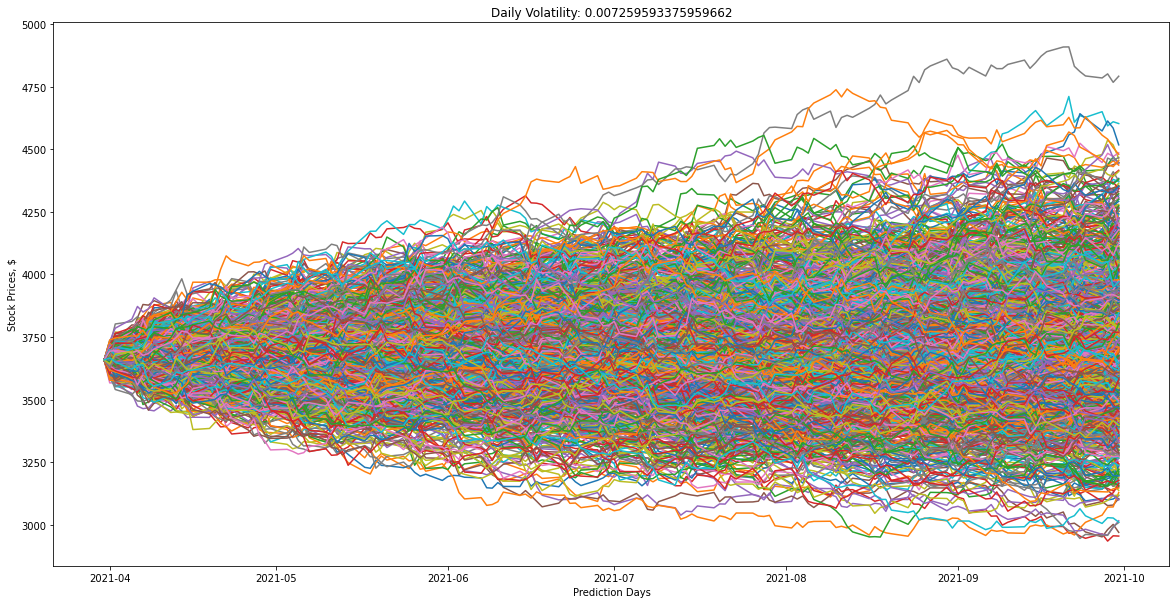

In [28]:
# Plotting the simulations
plt.figure(figsize = (20,10))
for i in range(scen_size):
    plt.title("Daily Volatility: " + str(sigma_trm))
    plt.plot(pd.date_range(start = df["Date"].max(), 
                end = pred_end_datei, freq = 'D').map(lambda x:
                x if x.isoweekday() in range(1, 6) else np.nan).dropna(), S_trm[i, :])
    plt.ylabel('Stock Prices, $')
    plt.xlabel('Prediction Days')
plt.show()

# Dataframe format for predictions - first 10 scenarios only
Preds_df_trm = pd.DataFrame(S_trm.swapaxes(0, 1)[:, :10]).set_index(
           pd.date_range(start = df["Date"].max(), 
           end = pred_end_datei, freq = 'D').map(lambda x:
           x if x.isoweekday() in range(1, 6) else np.nan).dropna()
           ).reset_index(drop = False)

## Simulación con detalles

### Compra Opción con parámetros aleatorios

In [29]:
#inputs
K = So #strike coffee base
K2 = So_trm #strike trm base
T = Tb / 365 #time in years

#dist strike vs spot 
max_days = 15 #maximo de días que pueden pasar
chosen_scen = random.randint(0,scen_size-1) #escenario del Movimiento Browniano simulado escogido
days_gone = random.randint(1,max_days) # Días pasados entre t0 y momento de comprar

S = S_c[chosen_scen][days_gone] #spot coffee BUY
S2 = S_trm[chosen_scen][days_gone] #spot trm BUY


#Combinacion de las dos primas
primas_pct = []
primas_pct2 = []
primas_pct_all = []


for i in range(n):
    #coffee
    r = lib[i] #free risk interest rate
    sigma = vol_coffee[i] #volatility of asset (annualized)
    prima = call(S,K,T,r,sigma) # price of option in unites
    prima_pct = prima / K #price of option %
    primas_pct.append(prima_pct)
    
    #trm
    r2 = ibr[i] - lib[i]
    sigma2 = vol_trm[i]
    prima2 = call(S2, K2, T, r2, sigma2)
    prima_pct2 = prima2 / K2
    primas_pct2.append(prima_pct2)
    
    #combinacion
    prima_pct_all = (prima_pct + prima_pct2)
    primas_pct_all.append(prima_pct_all)

In [30]:
primas_pct_all_arr = np.array(primas_pct_all)
prima_avg = primas_pct_all_arr.mean()
print("Escenario Escogido",chosen_scen)
print("Días pasados entre strike y spot",days_gone)
print("Spot café", So, "Strike Café", K)
print("Spot TRM", So_trm, "Strike trm", K2)
print("Costo prima promedio cobertura", round(prima_avg * 100,3), "%")

Escenario Escogido 169
Días pasados entre strike y spot 7
Spot café 123.5 Strike Café 123.5
Spot TRM 3658.95 Strike trm 3658.95
Costo prima promedio cobertura 10.795 %


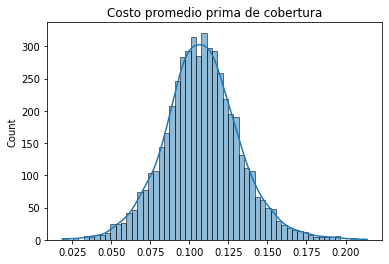

In [31]:
sns.histplot(primas_pct_all, kde=True)
plt.title("Costo promedio prima de cobertura")
plt.show()

Costo de capital

In [32]:
p995 = np.percentile(primas_pct_all_arr, 99.5)
p90 = np.percentile(primas_pct_all_arr, 90)
p10 = np.percentile(primas_pct_all_arr, 10)
KdC = 0.15
taxes = 0.7
margen = (p995 - prima_avg)*KdC
prima_obj = ((prima_avg + margen)/taxes)*pct_cobertura
prima_obj_base = ((p10 + margen)/taxes)*pct_cobertura
prima_obj_tope = ((p90 + margen)/taxes)*pct_cobertura

print("Costo Objetivo", round(prima_obj*100,3), "%")
print("Costo Objetivo base", round(prima_obj_base*100,3), "%")
print("Costo Objetivo tope", round(prima_obj_tope*100,3), "%")


Costo Objetivo 5.109 %
Costo Objetivo base 3.842 %
Costo Objetivo tope 6.392 %


### Bull Spread

Spot café 123.5 Strike Café 129.675 Techo Café 166.73
Spot TRM 3658.95 Strike trm 3841.8975 Techo trm 4939.58
Costo prima promedio cobertura 6.112 %
Costo Objetivo 2.865 %
Costo Objetivo base 2.108 %
Costo Objetivo tope 3.579 %


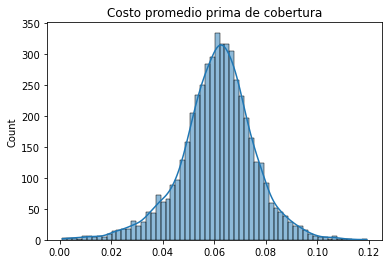

In [33]:
#inputs
S = So #spot coffee base
S2 = So_trm #spot trm base
T = Tb / 365 #time in years

#parámetros bull spread------------
deducible = 0.05 #Strike BUY
techo = 0.35 #Strike SELL
#----------------------------------

K = S*(1+deducible) #strike coffee BUY
K2 = S2*(1+deducible) #strike trm BUY

K_techo = S*(1+techo) #strike coffee BUY
K2_techo  = S2*(1+techo) #strike trm SELL

#Combinacion de las dos primas
primas_coffee_b = []
primas_coffee_s = []

primas_pct = []
primas_pct2 = []
primas_pct_all = []

for i in range(n):
    #coffee
    r = lib[i] #free risk interest rate
    sigma = vol_coffee[i] #volatility of asset (annualized)
    prima_b = call(S,K,T,r,sigma) # price of option in unites for BUY strategy
    primas_coffee_b.append(prima_b)
    prima_s = call(S,K_techo,T,r,sigma) # price of option in unites for SELL strategy
    primas_coffee_s.append(prima_s)
    prima = prima_b - prima_s
    prima_pct = prima / K #price of option %
    primas_pct.append(prima_pct)
    
    #trm
    r2 = ibr[i] - lib[i]
    sigma2 = vol_trm[i]
    prima2_b = call(S2, K2, T, r2, sigma2) # price of option in unites for BUY strategy
    prima2_s = call(S2, K2_techo, T, r2, sigma2) # price of option in unites for SELL strategy
    prima2 = prima2_b - prima2_s 
    prima_pct2 = prima2 / K2
    primas_pct2.append(prima_pct2)
    
    #combinacion
    prima_pct_all = (prima_pct + prima_pct2)
    primas_pct_all.append(prima_pct_all)
    

primas_pct_all_arr = np.array(primas_pct_all)
prima_avg = primas_pct_all_arr.mean()

print("Spot café", So, "Strike Café", K, "Techo Café", round(K_techo,2))
print("Spot TRM", So_trm, "Strike trm", K2, "Techo trm", round(K2_techo,2))
print("Costo prima promedio cobertura", round(prima_avg * 100,3), "%")

p995 = np.percentile(primas_pct_all_arr, 99.5)
p90 = np.percentile(primas_pct_all_arr, 90)
p10 = np.percentile(primas_pct_all_arr, 10)
KdC = 0.15
taxes = 0.7
margen = (p995 - prima_avg)*KdC
prima_obj = ((prima_avg + margen)/taxes)*pct_cobertura
prima_obj_base = ((p10 + margen)/taxes)*pct_cobertura
prima_obj_tope = ((p90 + margen)/taxes)*pct_cobertura

print("Costo Objetivo", round(prima_obj*100,3), "%")
print("Costo Objetivo base", round(prima_obj_base*100,3), "%")
print("Costo Objetivo tope", round(prima_obj_tope*100,3), "%")

sns.histplot(primas_pct_all, kde=True)
plt.title("Costo promedio prima de cobertura")
plt.show()

### P&G Café

In [102]:
#Strike Buy = K
#Strike Sell = K_techo

#1 contract = 37500 lb
c_size = 37500

#Price Buy
primas_coffee_b_array = np.array(primas_coffee_b)
price_b = primas_coffee_b_array.mean() # strike promedio
price_b10 = np.percentile(primas_coffee_b_array, 10) #strike pctl 10
price_b90 = np.percentile(primas_coffee_b_array, 90) #strike pctl 90

#Price Sell
primas_coffee_s_array = np.array(primas_coffee_s)
price_s = primas_coffee_s_array.mean() # strike promedio
price_s10 = np.percentile(primas_coffee_s_array, 10) #strike pctl 10
price_s90 = np.percentile(primas_coffee_s_array, 90) #strike pctl 90

#Price Total
primas_total_array = primas_coffee_b_array - primas_coffee_s_array
p995_total = np.percentile(primas_total_array, 99.5)
price_total = price_b - price_s
KdC = 0.15
taxes = 0.7
margen_total = (p995_total - price_total)*KdC
prima_total = ((price_total + margen_total)/taxes)



#Spot
df_spot_coffee = Preds_df_coffee.set_index("index") # dataframe con predicciones del Movimiento Browniano

#Return from call buy = IF(Spot > Strike, Spot - Strike - Price, Else, -Price)
#Return from call sell = IF(Spot > Strike, Strike - Spot + Price, Else, +Price)
pnl_b = []
pnl_s = []
pnl = []
scenarios = df_spot_coffee.columns
for spot in df_spot_coffee[0]:
    if spot > K:
        profit_b = spot - K - price_b
        profit_s = K_techo - spot + price_s
    else:
        profit_b = - price_b
        profit_s = price_s
    pnl_b.append(profit_b)
    pnl_s.append(profit_s)
    
    
print("Strike Buy",K ,"Prima Buy", round(price_b,2))
print("Strike Sell",round(K_techo,2) ,"Prima Sell", round(price_s,2))

aleatorio = random.randint(0,9)
    
df_pnl = df_spot_coffee[[aleatorio]]
df_pnl["P&L Buy"] = pnl_b
df_pnl["P&L Sell"] = pnl_s
df_pnl["P&L Opcion"] = df_pnl["P&L Buy"] + df_pnl["P&L Sell"]



df_pnl.head()

Strike Buy 129.675 Prima Buy 8.33
Strike Sell 166.73 Prima Sell 1.45


<ipython-input-102-2b730208b9a5>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pnl["P&L Buy"] = pnl_b
<ipython-input-102-2b730208b9a5>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pnl["P&L Sell"] = pnl_s
<ipython-input-102-2b730208b9a5>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

,1,P&L Buy,P&L Sell,P&L Opcion
index,,,,
2021-03-31,123.500000,-8.332784,1.454849,-6.877935
2021-04-01,123.182677,-8.332784,1.454849,-6.877935
2021-04-02,123.206624,-8.332784,1.454849,-6.877935
2021-04-05,124.252478,-8.332784,1.454849,-6.877935
2021-04-06,123.340183,-8.332784,1.454849,-6.877935


In [113]:
df_pnl.reset_index(inplace = True)
pygs = []
for i in range(len(df_pnl)):
    spot = df_pnl.iloc[i,1]
    if spot <= K:
        pyg = prima_total - price_total
    else:
        pyg = 0
    pygs.append(pyg)

<AxesSubplot:ylabel='Count'>

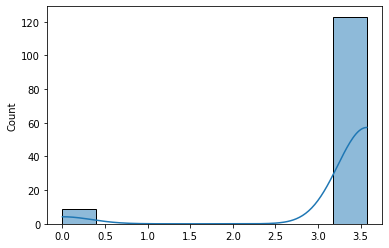

In [114]:
sns.histplot(pygs, kde = True)

In [105]:
df_pnl["P&G Sura"] = pygs
df_pnl.set_index("index", inplace = True)

<ipython-input-105-b2f477065102>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pnl["P&G Sura"] = pygs


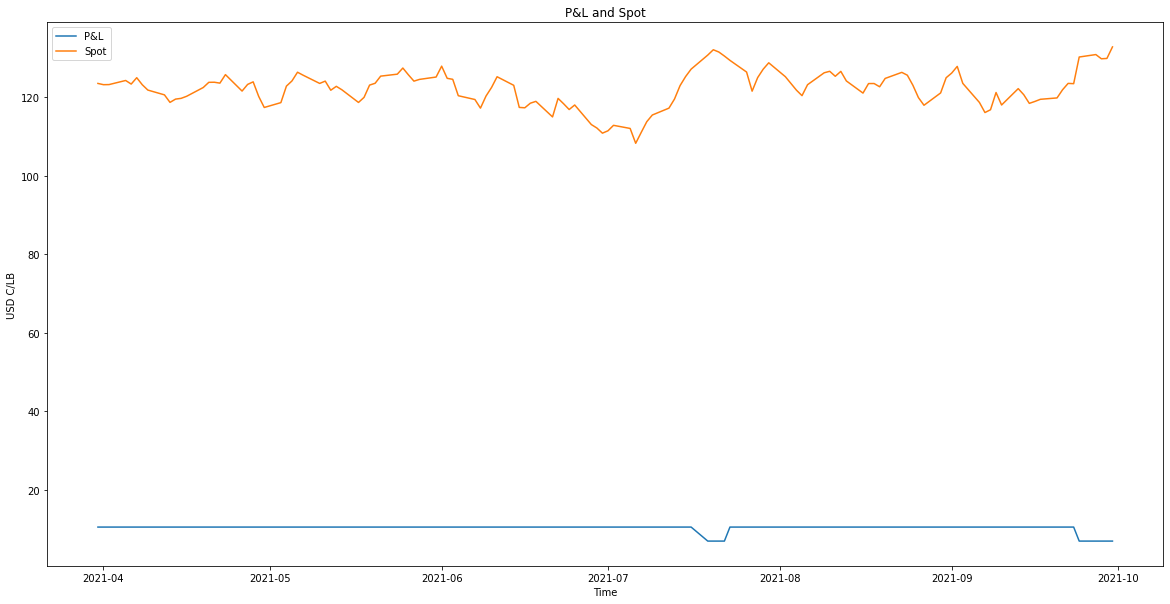

In [106]:
plt.figure(figsize = (20,10))
plt.plot(df_pnl[["P&G Sura"]], label ="P&L")
plt.plot(df_pnl[[ aleatorio]], label ="Spot")
plt.legend()
plt.xlabel("Time")
plt.ylabel("USD C/LB")
plt.title("P&L and Spot")
plt.show()

### Multiple Scenario P&L

In [115]:
#Strike Buy = K
#Strike Sell = K_techo

#1 contract = 37500 lb
c_size = 37500

#Price Buy
primas_coffee_b_array = np.array(primas_coffee_b)
price_b = primas_coffee_b_array.mean() # strike promedio
price_b10 = np.percentile(primas_coffee_b_array, 10) #strike pctl 10
price_b90 = np.percentile(primas_coffee_b_array, 90) #strike pctl 90

#Price Sell
primas_coffee_s_array = np.array(primas_coffee_s)
price_s = primas_coffee_s_array.mean() # strike promedio
price_s10 = np.percentile(primas_coffee_s_array, 10) #strike pctl 10
price_s90 = np.percentile(primas_coffee_s_array, 90) #strike pctl 90

#Price Total
primas_total_array = primas_coffee_b_array - primas_coffee_s_array
p995_total = np.percentile(primas_total_array, 99.5)
price_total = price_b - price_s
KdC = 0.15
taxes = 0.7
margen_total = (p995_total - price_total)*KdC
prima_total = ((price_total + margen_total)/taxes)



#Spot
df_spot_coffee = Preds_df_coffee.set_index("index") # dataframe con predicciones del Movimiento Browniano

#Return from call buy = IF(Spot > Strike, Spot - Strike - Price, Else, -Price)
#Return from call sell = IF(Spot > Strike, Strike - Spot + Price, Else, +Price)
pygs_all = []
pygs_opcion = []
scenarios = df_spot_coffee.columns
for scenario in scenarios:
    pnl_b = [] #lista con los p&l de la compra
    pnl_s = [] #lista con los p&l de la venta
    pnl = [] #lista con los p&l del escenario
    pygs = [] #lista de todos los p&ls´ posibles
    for spot in df_spot_coffee[scenario]:
        if spot > K:
            pyg = 0
        else:
            pyg = prima_total - price_total
        pygs.append(pyg)
    pygs_all.append(pygs)

In [116]:
#unpack
pygs_all_u = []
for lista in pygs_all:
    for item in lista:
        pygs_all_u.append(item)

<AxesSubplot:ylabel='Count'>

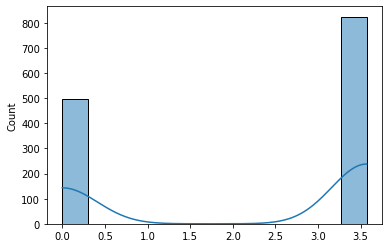

In [117]:
sns.histplot(pygs_all_u, kde = True)